# BERT로 텍스트 분류

이번 튜토리얼에서는 BERT를 미세 조정하여 일반 텍스트 IMDB 영화 리뷰 데이터 세트에 대한 감정 분석을 수행하는 완전한 코드가 포함되어 있습니다. 모델 학습 외에도 텍스트를 적절한 형식으로 사전 처리하는 방법을 배웁니다.

아래와 같은 순서로 진행됩니다.

+ IMDB 데이터 세트 로드
+ TensorFlow Hub에서 BERT 모델 로드
+ BERT와 분류기를 결합하여 자신 만의 모델 구축
+ 자신의 모델을 훈련시키고 그 일부로 BERT 미세 조정
+ 모델 저장 및 이를 활용한 문장 분류

## BERT 정보

BERT 및 기타 Transformer 인코더 아키텍처는 NLP(자연어 처리)의 다양한 작업에서 크게 성공적이었습니다. 딥 러닝 모델에 사용하기에 적합한 자연어의 벡터 공간 표현을 계산합니다. BERT 모델은 Transformer 인코더 아키텍처를 사용해서 전체 모든 토큰의 context 안에서 입력 텍스트의 각 토큰을 처리합니다. BERT는 Bidirectional Encoder Representations from Transformers의 약자입니다.

BERT 모델은 텍스트의 큰 범위에서 사전 훈련을 거치고, 특정 작업에 맞게 튜닝합니다.

## 설정

In [1]:
!pip install -q -U tensorflow-text

     |████████████████████████████████| 4.3 MB 28.2 MB/s 


AdamW 옵티마지어를 사용할 것입니다.

In [2]:
!pip install -q tf-models-official

     |████████████████████████████████| 1.6 MB 31.7 MB/s 
     |████████████████████████████████| 211 kB 50.4 MB/s 
     |████████████████████████████████| 1.2 MB 27.2 MB/s 
     |████████████████████████████████| 352 kB 56.2 MB/s 
     |████████████████████████████████| 636 kB 47.7 MB/s 
     |████████████████████████████████| 679 kB 41.2 MB/s 
     |████████████████████████████████| 99 kB 8.9 MB/s 
     |████████████████████████████████| 37.1 MB 46 kB/s 
     |████████████████████████████████| 54 kB 2.6 MB/s 
     |████████████████████████████████| 43 kB 1.9 MB/s 


In [3]:
import os
import shutil

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization

import matplotlib.pyplot as plt

tf.get_logger().setLevel('ERROR')

## Sentiment 분석

이번 튜토리얼에서는 Sentiment 분석 모델을 이용해서 리뷰의 텍스트를 기반으로 긍정 혹은 부정으로 영화 리뷰를 분류할 것입니다.

여기에서 Internet Movie Database로부터 50,000개의 영화 리뷰가 포함된 Large Movie Review Dataset을 이용할 것입니다.

### IMDB 데이터세트 다운로드

데이터세트를 다운로드하고 디렉토리 구조를 파악해봅시다.

In [4]:
url = 'https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz'

dataset = tf.keras.utils.get_file('aclImdb_v1.tar.gz', url,
                                  untar=True, cache_dir='.',
                                  cache_subdir='')
dataset_dir = os.path.join(os.path.dirname(dataset), 'aclImdb')
train_dir = os.path.join(dataset_dir, 'train')

remove_dir = os.path.join(train_dir, 'unsup')
shutil.rmtree(remove_dir)

84131840/84125825 [==============================] - 3s 0us/step


다음으로, `text_dataset_from_directory` 유틸리티를 사용해서 레이블되어 있는 `tf.data.Dataset`을 생성할 것입니다.

IMDB 데이터셋은 이미 훈련과 테스트 셋으로 나뉘어져 있지만, 검증 셋이 부족합니다. 따라서 80:20으로 훈련 데이터세트를 훈련과 검증 셋으로 나눌 것입니다.

주의 : `validation_split` 또는 `subset`으로 훈련과 검증 셋으로 나눌 때 반드시 랜덤 `seed` 또는 `shuffle=False` 인자를 주어야 훈련과 검증 셋 사이에 데이터가 겹치지 않습니다.

In [5]:
AUTOTUNE = tf.data.AUTOTUNE
batch_size = 32
seed = 42

raw_train_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'aclImdb/train',
    batch_size=batch_size,
    validation_split=0.2,
    subset='training',
    seed=seed
)

class_names=raw_train_ds.class_names
train_ds = raw_train_ds.cache().prefetch(buffer_size=AUTOTUNE)

val_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'aclImdb/train',
    batch_size=batch_size,
    validation_split=0.2,
    subset='validation',
    seed=seed
)

val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

test_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'aclImdb/test',
    batch_size=batch_size
)

test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.
Found 25000 files belonging to 2 classes.
Using 5000 files for validation.
Found 25000 files belonging to 2 classes.


In [6]:
for text_batch, label_batch in train_ds.take(1):
    for i in range(3):
        print(f'Review: {text_batch.numpy()[i]}')
        label = label_batch.numpy()[i]
        print(f'Label : {label} ({class_names[label]})')

Review: b'"Pandemonium" is a horror movie spoof that comes off more stupid than funny. Believe me when I tell you, I love comedies. Especially comedy spoofs. "Airplane", "The Naked Gun" trilogy, "Blazing Saddles", "High Anxiety", and "Spaceballs" are some of my favorite comedies that spoof a particular genre. "Pandemonium" is not up there with those films. Most of the scenes in this movie had me sitting there in stunned silence because the movie wasn\'t all that funny. There are a few laughs in the film, but when you watch a comedy, you expect to laugh a lot more than a few times and that\'s all this film has going for it. Geez, "Scream" had more laughs than this film and that was more of a horror film. How bizarre is that?<br /><br />*1/2 (out of four)'
Label : 0 (neg)
Review: b"David Mamet is a very interesting and a very un-equal director. His first movie 'House of Games' was the one I liked best, and it set a series of films with characters whose perspective of life changes as they

## TensorFlow Hub에서 모델 로드

TensorFlow Hub에서 로드할 BERT 모델을 선택하고 튜닝할 수 있습니다. 사용 가능한 여러 BERT 모델이 있습니다.

+ [BERT-Base](https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3), [Uncased](https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3), [seven more models](https://tfhub.dev/google/collections/bert/1) : 훈련된 가중치를 가지고 있는 오리지널 BERT 저자로부터 릴리즈된 모델입니다.
+ [Small BERTs](https://tfhub.dev/google/collections/bert/1)는 같은 생성 아키텍처이지만 더 작은 변환기 블럭을 가지고 있어 속도, 크기, 품질 간에 tradeoff를 해야합니다.
+ [ALBERT](https://tfhub.dev/google/collections/albert/1) : 레이어 사이에 파라미터를 공유함으로써 모델 사이즈를 줄인 "A Lite BERT"의 4가지 다른 사이즈가 있습니다.
+ [BERT Experts](https://tfhub.dev/google/collections/experts/bert/1) : BERT-Base 아키텍처를 가진 8개의 모델이 있습니다. 하지만 서로 다른 사전 훈련 도메인 사이에 선택할 수 있도록 해서 타겟 작업에 더 근접한 결과를 도출해낼 수 있도록 해줍니다.
+ [Electra](https://tfhub.dev/google/collections/electra/1) : BERT와 같은 아키텍처를 가지지만 (3개의 서로 다른 사이즈에서) a Generative Adversarial Network (GAN)과 유사한 세팅인 판별자로서 사전 학습됩니다.
+ BERT with Talking-Heads Attention and Gated GELU [[base](https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_base/1), [large](https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_large/1)] : 변환기 아키텍처의 코어에 2가지를 개선했습니다.

텐서플로 허브에서 모델에 대한 더 자세한 설명과 연구 논문에 대한 레퍼런스를 보여줍니다. [`tfhub.dev`](http://tfhub.dev)를 참고하시기 바랍니다.

Small BERT를 사용하는 것이 fine-tune을 하기에 더 빠르므로 초심자에게 추천하지만 만약 작은 모델인데 높은 정확도를 얻고 싶다면, ALBERT를 추천합니다. 만약 더 좋은 정확도를 얻기를 원한다면, 클래식 BERT 사이즈인 Electra, Talking Heads, BERT Expert 중에 하나를 선택하세요.

이제 모델을 선택할텐데 아래에서 사용할 수 있는 모델 외에도 더 나은 정확도를 갖는 여러 버전의 모델이 있지만 단일 GPU에서 미세 조정하기에는 너무 모델의 사이즈가 큽니다.

### 미세 조정할 BERT 모델 선택

In [7]:
bert_model_name = 'small_bert/bert_en_uncased_L-4_H-512_A-8' 

map_name_to_handle = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-768_A-12/1',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_base/2',
    'electra_small':
        'https://tfhub.dev/google/electra_small/2',
    'electra_base':
        'https://tfhub.dev/google/electra_base/2',
    'experts_pubmed':
        'https://tfhub.dev/google/experts/bert/pubmed/2',
    'experts_wiki_books':
        'https://tfhub.dev/google/experts/bert/wiki_books/2',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_base/1',
}

map_model_to_preprocess = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_preprocess/3',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_preprocess/3',
    'electra_small':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'electra_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_pubmed':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_wiki_books':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
}

tfhub_handle_encoder = map_name_to_handle[bert_model_name]
tfhub_handle_preprocess = map_model_to_preprocess[bert_model_name]

print(f'BERT model selected           : {tfhub_handle_encoder}')
print(f'Preprocess model auto-selected: {tfhub_handle_preprocess}')

BERT model selected           : https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Preprocess model auto-selected: https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3


## 모델 전처리

텍스트 입력은 BERT에 입력되기 전에 숫자 토큰 ID로 변환되고 여러 Tensor로 정렬되어야합니다. TensorFlow Hub는 각 BERT 모델에 대해 일치하는 전처리 모델을 제공하며, TF.text 라이브러리의 TF작업을 사용하여 변환을 구현합니다. 텍스트를 전처리하기 위해 TensorFlow 모델 외부에서 Python 코드를 실행할 필요는 없습니다.

전처리 모델은 위의 코드에서 `tfhub_handle_preprocess`에 담겨있으며, `hub.KerasLayer`에 로드하면 미세 조정된 모델을 구성하게 됩니다.

In [8]:
bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)

일부 텍스트를 전처리 모델에 입력하고 출력해보겠습니다.

In [9]:
text_test = ['this is such an amazing movie!']
text_preprocessed = bert_preprocess_model(text_test)

print(f'Keys        : {list(text_preprocessed.keys())}')
print(f'Shape       : {text_preprocessed["input_word_ids"].shape}')
print(f'Word Ids    : {text_preprocessed["input_word_ids"][0, :12]}')
print(f'Input Mask  : {text_preprocessed["input_mask"][0, :12]}')
print(f'Type Ids    : {text_preprocessed["input_type_ids"][0, :12]}')

Keys        : ['input_word_ids', 'input_mask', 'input_type_ids']
Shape       : (1, 128)
Word Ids    : [ 101 2023 2003 2107 2019 6429 3185  999  102    0    0    0]
Input Mask  : [1 1 1 1 1 1 1 1 1 0 0 0]
Type Ids    : [0 0 0 0 0 0 0 0 0 0 0 0]


BERT 전처리 모델은 `input_words_id`, `input_mask`, `input_type_ids`라는 3개의 출력을 갖습니다.

입력은 128개의 토큰으로 잘립니다. 토큰 수는 설정할 수 있습니다.

`input_type_ids`는 단일 문장 입력이므로 하나의 값(0)만 갖습니다. 여러 문장이 입력되면 각 문장마다 하나의 숫자가 대응됩니다.

## BERT 모델 사용

BERT 모델을 사용하기 전 앞서 전처리된 입력을 넣고 출력을 살펴보겠습니다.

In [10]:
bert_model = hub.KerasLayer(tfhub_handle_encoder)

In [11]:
bert_results = bert_model(text_preprocessed)

print(f'Loaded BERT: {tfhub_handle_encoder}')
print(f'Pooled Outputs Shape:{bert_results["pooled_output"].shape}')
print(f'Pooled Outputs Values:{bert_results["pooled_output"][0, :12]}')
print(f'Sequence Outputs Shape:{bert_results["sequence_output"].shape}')
print(f'Sequence Outputs Values:{bert_results["sequence_output"][0, :12]}')

Loaded BERT: https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Pooled Outputs Shape:(1, 512)
Pooled Outputs Values:[ 0.76262903  0.99280983 -0.18611853  0.3667385   0.15233739  0.6550446
  0.9681154  -0.9486271   0.00216157 -0.9877732   0.06842728 -0.97630596]
Sequence Outputs Shape:(1, 128, 512)
Sequence Outputs Values:[[-0.28946295  0.34321263  0.33231527 ...  0.2130087   0.71020836
  -0.05771071]
 [-0.2874208   0.31981027 -0.23018518 ...  0.5845508  -0.21329744
   0.7269212 ]
 [-0.66157013  0.6887687  -0.8743292  ...  0.10877226 -0.26173285
   0.47855547]
 ...
 [-0.22561097 -0.2892568  -0.07064426 ...  0.47566074  0.83277184
   0.40025318]
 [-0.29824227 -0.27473107 -0.05450526 ...  0.488498    1.0955358
   0.18163362]
 [-0.4437815   0.00930744  0.07223801 ...  0.17290124  1.1833242
   0.07898009]]


BERT 모델은 `pooled_output`, `sequence_output`, `encoder_outputs`라는 3개의 출력을 갖습니다.

+ `sequence_output` : 문맥 안에서 각 입력 토큰을 나타냅니다. 형태는 [`batch_size`, `seq_length`, `H`]로 나타납니다. 영화 리뷰 내의 모든 토큰에 대해 문맥상 맞는 임베딩이라고 생각할 수 있습니다.
+ `pooled_output` : 입력 시퀀스 하나를 전체로 나타냅니다. 형태는 [`batch_size`, `H`]이고, 영화 리뷰 전체에 대한 임베딩으로 생각할 수 있습니다.
+ `encoder_outputs` : `output["encoder_outputs"][i]`는 0 <= i < L 범위에서 i번째 변환기 블럭의 출력이 함께하는 `[batch_size, seq_length, 1024]` 형태의 텐서입니다. 이 리스트의 가장 마지막 값은 `sequence_output`과 같습니다.

미세조정 과정에서는 `pooled_output`을 이용합니다.

## 모델 정의하기

BERT 전처리 모델, BERT 모델, 하나의 Dense와 하나의 Dropout 레이어로 정말 간단한 미세조정 모델을 만들어보겠습니다.

In [16]:
def build_classifier_model():
    text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
    preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
    encoder_inputs = preprocessing_layer(text_input)
    encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
    outputs = encoder(encoder_inputs)
    net = outputs['pooled_output']
    net = tf.keras.layers.Dropout(0.1)(net)
    net = tf.keras.layers.Dense(1, activation=None, name='classifier')(net)
    return tf.keras.Model(text_input, net)

In [17]:
classifier_model = build_classifier_model()
bert_raw_result = classifier_model(tf.constant(text_test))
print(tf.sigmoid(bert_raw_result))

tf.Tensor([[0.51660347]], shape=(1, 1), dtype=float32)


모델이 아직 훈련되지 않았기 때문에 결과는 의미가 없습니다.

모델의 구조를 살펴보겠습니다.

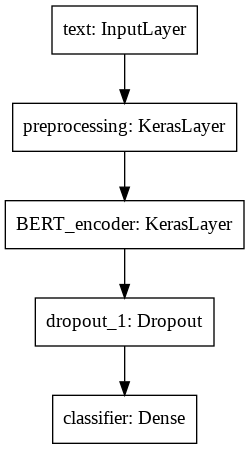

In [18]:
tf.keras.utils.plot_model(classifier_model)

## 모델 훈련

### 손실 기능

이진 분류 문제이고 모델이 확률을 출력합니다. 따라서 `losses.BinaryCrossentropy` 손실 함수를 사용합니다.

In [19]:
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
metrics = tf.metrics.BinaryAccuracy()

### 옵티마이저

옵티마이저로는 "Adaptive Moments"(Adam)을 사용하겠습니다. 예측 손실을 최소화하고 `AdamW`라고도 알려진 가중치 감소로 정규화를 수행합니다.

학습률(`init_lr`)의 경우 학습 단계의 처음 10%(`num_warmup_steps`)에 걸쳐 선형 워밍업 단계가 이루어집니다. 이때 초기 학습률이 선형 감쇠를 이루게 됩니다. BERT 논문에 다르면 초기 학습률은 미세 조정의 경우에 더 작습니다.(5e-5, 3e-5, 2e-5가 가장 좋습니다)

In [20]:
epochs = 5
steps_per_epoch = tf.data.experimental.cardinality(train_ds).numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

### BERT 모델 로드 및 훈련

`classifier_model`을 컴파일합니다.



In [21]:
classifier_model.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)

In [22]:
print(f'Training model with {tfhub_handle_encoder}')
history = classifier_model.fit(x=train_ds,
                               validation_data=val_ds,
                               epochs=epochs)

Training model with https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Epoch 1/5
625/625 [==============================] - 179s 275ms/step - loss: 0.4865 - binary_accuracy: 0.7386 - val_loss: 0.3777 - val_binary_accuracy: 0.8356
Epoch 2/5
625/625 [==============================] - 166s 266ms/step - loss: 0.3309 - binary_accuracy: 0.8506 - val_loss: 0.4201 - val_binary_accuracy: 0.8432
Epoch 3/5
625/625 [==============================] - 166s 266ms/step - loss: 0.2492 - binary_accuracy: 0.8952 - val_loss: 0.3967 - val_binary_accuracy: 0.8476
Epoch 4/5
625/625 [==============================] - 166s 265ms/step - loss: 0.1910 - binary_accuracy: 0.9240 - val_loss: 0.4532 - val_binary_accuracy: 0.8496
Epoch 5/5
625/625 [==============================] - 166s 265ms/step - loss: 0.1542 - binary_accuracy: 0.9409 - val_loss: 0.4993 - val_binary_accuracy: 0.8482


### 모델 평가


In [23]:
loss, accuracy = classifier_model.evaluate(test_ds)

print(f"Loss: {loss}")
print(f"Accuracy: {accuracy}")

782/782 [==============================] - 96s 122ms/step - loss: 0.4692 - binary_accuracy: 0.8543
Loss: 0.4691661596298218
Accuracy: 0.8543199896812439


### 시간 경과에 따른 정확도와 손실 도표

`model.fit()`에 의해 반환된 `History` 객체를 기반으로 합니다. 비교를 위해 훈련 및 검증 손실과 정확도를 플로팅할 수 있습니다.

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])


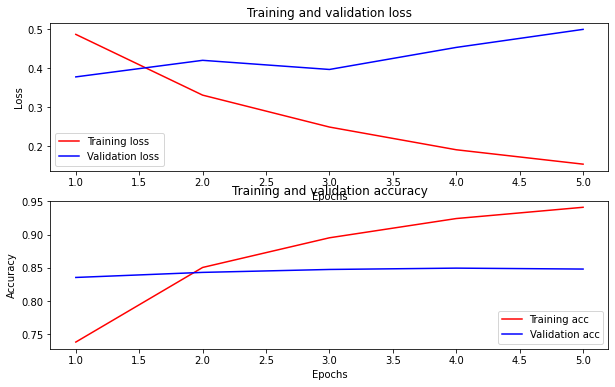

In [24]:
history_dict = history.history
print(history_dict.keys())

acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

plt.subplot(2, 1, 1)
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

## 추론을 위한 내보내기

미세 조정된 모델을 저장해보겠습니다.

In [25]:
dataset_name = 'imdb'
saved_model_path = './{}_bert'.format(dataset_name.replace('/','_'))

classifier_model.save(saved_model_path, include_optimizer=False)

모델을 다시 로드하여 원하는 문장으로 테스트해보겠습니다.

In [28]:
reloaded_model = tf.saved_model.load(saved_model_path)

def print_my_examples(inputs, results):
    result_for_printing = [f'input: {inputs[i]:<30} : score: {results[i][0]:.6f}' 
                           for i in range(len(inputs))]
    print(*result_for_printing, sep='\n')
    print()

examples = [
    'this is such an amazing movie!',  # this is the same sentence tried earlier
    'The movie was great!',
    'The movie was meh.',
    'The movie was okish.',
    'The movie was terrible...'
]

reloaded_results = tf.sigmoid(reloaded_model(tf.constant(examples)))
original_results = tf.sigmoid(classifier_model(tf.constant(examples)))

print('Results from the saved model:')
print_my_examples(examples, reloaded_results)
print('Results from the model in memory:')
print_my_examples(examples, original_results)

Results from the saved model:
input: this is such an amazing movie! : score: 0.999393
input: The movie was great!           : score: 0.995965
input: The movie was meh.             : score: 0.952108
input: The movie was okish.           : score: 0.075861
input: The movie was terrible...      : score: 0.001017

Results from the model in memory:
input: this is such an amazing movie! : score: 0.999393
input: The movie was great!           : score: 0.995965
input: The movie was meh.             : score: 0.952108
input: The movie was okish.           : score: 0.075861
input: The movie was terrible...      : score: 0.001017



기존 모델과 기존 모델을 저장하고 로드한 모델의 결과가 같은 것을 보아 모델이 저장되고 로드될 때 훈련에 있어 변경되는 부분이 없는 것을 알 수 있습니다.

TF Serving 에서 모델을 사용하려면 `signatures`를 통해 모델을 호출해야합니다. 이후 확률값이 `classifier`안으로 들어가게 됩니다. 딕셔너리를 이용해 key값 `classifier`에 해당하는 value값을 `tf.sigmoid`해서 결괏값을 얻어낼 수 있습니다.

In [29]:
serving_results = reloaded_model.signatures['serving_default'](tf.constant(examples))

serving_results = tf.sigmoid(serving_results['classifier'])

print_my_examples(examples, serving_results)

input: this is such an amazing movie! : score: 0.999393
input: The movie was great!           : score: 0.995965
input: The movie was meh.             : score: 0.952108
input: The movie was okish.           : score: 0.075861
input: The movie was terrible...      : score: 0.001017

